In [1]:
from __future__ import annotations

import dataclasses
import json
import pathlib

import cv2
import h5py
import hdf5plugin
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import tqdm
from rpg_e2vid.utils.inference_utils import events_to_voxel_grid
from rpg_e2vid.utils.loading_utils import load_model

import const
import utils

In [2]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
MODEL_PATH = pathlib.Path("../pretrained/E2VID_lightweight.pth.tar")
RPG_EVENTS_PATH = pathlib.Path("./parsed/")
INTERLAKEN_EVENTS_PATH = pathlib.Path("../data/raw/dsec/interlaken_00_f/events.h5")

model = load_model(MODEL_PATH)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [4]:
events_rpg = utils.EventsData.from_path(RPG_EVENTS_PATH / "street2.bin")

In [5]:
with h5py.File(INTERLAKEN_EVENTS_PATH, "r") as events_file:
    te_offset = events_file["t_offset"][()]
    x = (events_file["events"]["x"][:]).astype(np.float32)
    y = (events_file["events"]["y"][:]).astype(np.float32)
    t = (events_file["events"]["t"][:] / 1000).astype(int) + int(te_offset / 1000)
    p = (events_file["events"]["p"][:]).astype(np.float32)

    events_arr = np.array([t, x, y, p]).T
events_dsec = utils.EventsData(
    events_arr,
    width=int(events_arr[:, 1].max() + 1),
    height=int(events_arr[:, 2].max() + 1),
)

In [6]:
_, ev_dsec_counts = np.unique(events_dsec.array[:, 0], return_counts=True)
_, ev_rpg_counts = np.unique(events_rpg.array[:, 0], return_counts=True)

In [47]:
rpg_eit = utils.EventWindowIterator(events_rpg.array, ev_rpg_counts, 50, 50)
out = cv2.VideoWriter(
    "check-rpg.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    20,
    (events_rpg.width * 2, events_rpg.height),
)

prev = None
for window in tqdm.tqdm(rpg_eit, total=len(rpg_eit)):
    events = window
    voxel_grid = events_to_voxel_grid(events, 5, events_rpg.width, events_rpg.height)
    voxel_grid = voxel_grid[None, ...]
    voxel_grid = torch.from_numpy(voxel_grid).float()
    with torch.no_grad():
        pred_2, prev = model(voxel_grid, prev)
        pred_2 = (pred_2.squeeze().cpu().numpy() * 255).astype(np.uint8)

    window_img = np.zeros((events_rpg.height, events_rpg.width, 3), dtype=np.uint8)
    xs = window[:, 1].astype(int)
    ys = window[:, 2].astype(int)
    window_img[ys, xs, 2] = window[:, 3] * 255
    window_img[ys, xs, 1] = 0
    window_img[ys, xs, 0] = (1 - window[:, 3]) * 255
    pred_2 = cv2.cvtColor(pred_2, cv2.COLOR_GRAY2BGR)
    side_by_side = np.concatenate((window_img, pred_2), axis=1)
    out.write(side_by_side)
out.release()

100%|██████████| 418/418 [02:49<00:00,  2.47it/s]


In [73]:
dsec_eit = utils.EventWindowIterator(events_dsec.array, ev_dsec_counts, 50, 50)
out = cv2.VideoWriter(
    "check-dsec.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    20,
    (events_rpg.width * 2, events_rpg.height),
)

prev = None
for i, window in tqdm.tqdm(enumerate(dsec_eit), total=len(dsec_eit)):
    events = window
    voxel_grid = events_to_voxel_grid(events, 5, events_rpg.width, events_rpg.height)
    voxel_grid = voxel_grid[None, ...]
    voxel_grid = torch.from_numpy(voxel_grid).float()
    if i % 5 == 0:
        prev = None

    with torch.no_grad():
        pred_2, prev = model(voxel_grid, prev)
        pred_2 = (pred_2.squeeze().cpu().numpy() * 255).astype(np.uint8)

    window_img = np.zeros((events_rpg.height, events_rpg.width, 3), dtype=np.uint8)
    xs = window[:, 1].astype(int)
    ys = window[:, 2].astype(int)
    window_img[ys, xs, 2] = window[:, 3] * 255
    window_img[ys, xs, 1] = 0
    window_img[ys, xs, 0] = (1 - window[:, 3]) * 255
    pred_2 = cv2.cvtColor(pred_2, cv2.COLOR_GRAY2BGR)
    side_by_side = np.concatenate((window_img, pred_2), axis=1)
    out.write(side_by_side)
out.release()

  0%|          | 0/1491 [00:00<?, ?it/s]

100%|██████████| 1491/1491 [10:52<00:00,  2.28it/s]


In [7]:
from event_cnn_minimal.model.model import FlowNet

params = {
    "num_bins": 5,
    "skip_type": "sum",
    "recurrent_block_type": "convlstm",
    "num_encoders": 3,
    "base_num_channels": 32,
    "num_residual_blocks": 2,
    "use_upsample_conv": True,
    "norm": "none",
    "num_output_channels": 3,
}
model2 = FlowNet(unet_kwargs=params)
model2.load_state_dict(torch.load(MODEL_PATH.parent / "better_e2vid_weights_v5.pth"))
model2 = model2.cuda()

Using skip: <function skip_sum at 0x0000027F68699750>
Using UpsampleConvLayer (slow, but no checkerboard artefacts)
Kernel size 5
Skip type sum
norm none


C:\Users\njytwf\AppData\Local\Temp\ipykernel_1656\1765163755.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(MODEL_PATH.parent / "bett

In [13]:
dsec_eit = utils.EventWindowIterator(events_dsec.array, ev_dsec_counts, 30, 30)
out = cv2.VideoWriter(
    "check-dsec-be2vid-30.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    20,
    (events_rpg.width * 2, events_rpg.height),
)

prev = None
model2.reset_states()
for i, window in tqdm.tqdm(enumerate(dsec_eit), total=len(dsec_eit)):
    events = window
    voxel_grid = events_to_voxel_grid(events, 5, events_rpg.width, events_rpg.height)
    voxel_grid = voxel_grid[None, ...]
    voxel_grid = torch.from_numpy(voxel_grid).float().to("cuda")

    with torch.no_grad():
        pred_2 = model2(voxel_grid)
        pred_2 = (pred_2["image"].squeeze().cpu().numpy() * 255).astype(np.uint8)

    window_img = np.zeros((events_rpg.height, events_rpg.width, 3), dtype=np.uint8)
    xs = window[:, 1].astype(int)
    ys = window[:, 2].astype(int)
    window_img[ys, xs, 2] = window[:, 3] * 255
    window_img[ys, xs, 1] = 0
    window_img[ys, xs, 0] = (1 - window[:, 3]) * 255
    pred_2 = cv2.cvtColor(pred_2, cv2.COLOR_GRAY2BGR)
    side_by_side = np.concatenate((window_img, pred_2), axis=1)
    out.write(side_by_side)
out.release()

  3%|▎         | 64/2484 [00:11<07:00,  5.76it/s] 


KeyboardInterrupt: 

In [10]:
rpg_eit = utils.EventWindowIterator(events_rpg.array, ev_rpg_counts, 30, 30)
out = cv2.VideoWriter(
    "check-rpg-comp-30.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    20,
    (events_rpg.width * 3, events_rpg.height),
)

prev = None
model2.reset_states()
for i, window in tqdm.tqdm(enumerate(rpg_eit), total=len(rpg_eit)):
    events = window
    voxel_grid = events_to_voxel_grid(events, 5, events_rpg.width, events_rpg.height)
    voxel_grid = voxel_grid[None, ...]
    voxel_grid = torch.from_numpy(voxel_grid).float()

    with torch.no_grad():
        pred, prev = model(voxel_grid, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
        pred_2 = model2(voxel_grid)
        pred_2 = (pred_2["image"].squeeze().cpu().numpy() * 255).astype(np.uint8)

    window_img = np.zeros((events_rpg.height, events_rpg.width, 3), dtype=np.uint8)
    xs = window[:, 1].astype(int)
    ys = window[:, 2].astype(int)
    window_img[ys, xs, 2] = window[:, 3] * 255
    window_img[ys, xs, 1] = 0
    window_img[ys, xs, 0] = (1 - window[:, 3]) * 255
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
    pred_2 = cv2.cvtColor(pred_2, cv2.COLOR_GRAY2BGR)
    side_by_side = np.concatenate((window_img, pred, pred_2), axis=1)
    out.write(side_by_side)
out.release()

100%|██████████| 696/696 [19:47<00:00,  1.71s/it]


In [3]:
rect_map_path = pathlib.Path("../data/raw/dsec/interlaken_00_c/rectify_map.h5")
with h5py.File(rect_map_path, "r") as f:
    rect_map = f["rectify_map"][:]

In [4]:
from utils import get_rect_artifact_mask

In [ ]:
rect_artifact = get_rect_artifact_mask(rect_map)

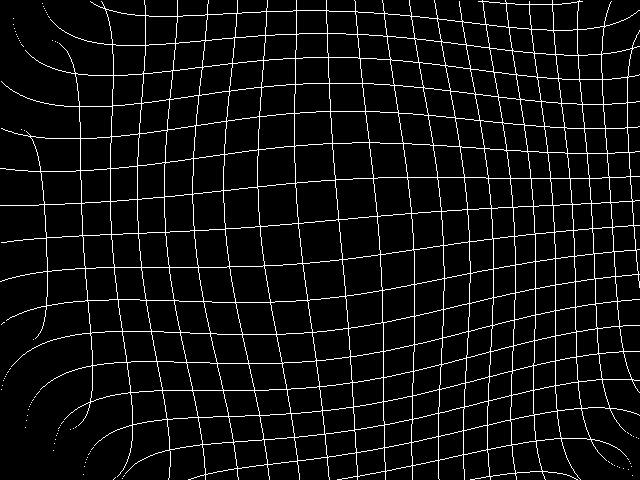

In [7]:
showarray((rect_artifact * 255).astype(np.uint8))

In [ ]:
rectify_img = np.zeros((480, 640), dtype=np.uint8)

# apply rectify map
for x, y in tqdm.tqdm(np.ndindex(rectify_img.shape), total=rectify_img.size):
    rect_x, rect_y = rect_map[x, y]
    rect_x, rect_y = int(rect_x), int(rect_y)
    if 0 <= rect_x < rectify_img.shape[1] and 0 <= rect_y < rectify_img.shape[0]:
        rectify_img[rect_y, rect_x] = 255

rect_artifact = (rectify_img == 0).astype(np.uint8) * 255

100%|██████████| 307200/307200 [00:00<00:00, 590690.71it/s]


In [ ]:
dsec_eit = utils.EventWindowIterator(events_dsec.array, ev_dsec_counts, 25, 25)
out = cv2.VideoWriter(
    "voxel-check.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    40,
    (events_rpg.width, events_rpg.height),
    isColor=False,
)
kernel = np.ones((3, 3), np.uint8)
kernel[1, 1] = 0
kernel = kernel / 8

model2.reset_states()
for i, window in tqdm.tqdm(enumerate(dsec_eit), total=len(dsec_eit)):
    window = window.copy()
    window[:, [1, 2]] = rect_map[
        window[:, 2].astype(int), window[:, 1].astype(int)
    ].copy()
    window = window[
        (window[:, 1] >= 0)
        & (window[:, 1] < rect_map.shape[1])
        & (window[:, 2] >= 0)
        & (window[:, 2] < rect_map.shape[0])
    ]
    voxel_grid = events_to_voxel_grid(window, 5, events_rpg.width, events_rpg.height)
    for i in range(voxel_grid.shape[0]):
        conved = cv2.filter2D(voxel_grid[i], -1, kernel)
        voxel_grid[i] = np.where(rect_artifact > 0, conved, voxel_grid[i])

    voxel_grid = voxel_grid[None, ...]
    voxel_grid = torch.from_numpy(voxel_grid).float().to("cuda")
    with torch.no_grad():
        pred_2 = model2(voxel_grid)
        pred_2 = (pred_2["image"].squeeze().cpu().numpy() * 255).astype(np.uint8)
    out.write(pred_2)
out.release()

  0%|          | 0/2981 [00:00<?, ?it/s]

100%|██████████| 2981/2981 [04:51<00:00, 10.22it/s]


In [11]:
dsec_eit = utils.EventWindowIterator(events_dsec.array, ev_dsec_counts, 25, 25)
model2.reset_states()
for i, window in tqdm.tqdm(enumerate(dsec_eit), total=len(dsec_eit)):
    window = window.copy()
    window[:, [1, 2]] = rect_map[
        window[:, 2].astype(int), window[:, 1].astype(int)
    ].copy()
    window = window[
        (window[:, 1] >= 0)
        & (window[:, 1] < rect_map.shape[1])
        & (window[:, 2] >= 0)
        & (window[:, 2] < rect_map.shape[0])
    ]
    voxel_grid = events_to_voxel_grid(window, 5, events_rpg.width, events_rpg.height)

    if i > 391:
        break

 13%|█▎        | 392/2981 [00:17<01:52, 23.00it/s]


In [12]:
c1 = voxel_grid[0]
c1_inp = cv2.inpaint(c1, rect_artifact, 3, cv2.INPAINT_TELEA)
c1_inp
c1_filled = c1.copy()
c1_filled[rect_artifact > 0] = 100
c1_filled

kernel = np.ones((3, 3), np.float32)
kernel[1, 1] = 0
kernel /= 8
c1_conv = cv2.filter2D(c1, -1, kernel)
c1_final = np.where(rect_artifact > 0, c1_conv, c1)
c1_final

array([[ 0.        ,  0.        ,  0.33333334, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)